# KI in den Geschichtswissenschaften
Ein Vortrag des Historischen Seminars der Leibniz Universität Hannover an der GWLB am 10.02.2026.

# Struktur
1. Markov Ketten
   "Darstellen wie statisch der nächste Zustand gewählt wird"
	1. Definition
	2. Beispiel von Sonnig, Regen, Bewölkt
	3. Übergang zur Semantik von Worten
2. Word Embedding
   "Semantik von Worten erfassen"
	1. Vektoren als Ortsangaben
		1. Beispiel
	2. Semantische Ähnlichkeit durch relative Nähe
		1. $\vec{v_3}(\text{Königin})= (\vec{v}(\text{König})- \vec{v}(\text{Mann}))+ \vec{v}(\text{Frau})$
	3.  Als Wordembeddings wird TD-IDF **nicht** gewählt. Eher als Beispiel für einfaches messen von Wichtigkeit im Korpus
	4. Word2Vec
		1. *Continues Bag Of Words* (CBOW)
		2. Skip-Gran
		3. Cosine-Sim
3. Attention



In [1]:
%pip install graphviz
%pip install matplotlib
%pip install numpy
import matplotlib.pyplot as plt
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


---

## Markov-Ketten

### Einführung

Eine Markov-Kette ist ein mathematisches Modell zur Beschreibung von stochastischen Prozessen, bei denen die Zukunft nur vom gegenwärtigen Zustand abhängt, nicht von der Vergangenheit. Diese Eigenschaft wird als **Markov-Eigenschaft** oder **Gedächtnislosigkeit** bezeichnet.

#### Formale Definition

Eine Markov-Kette ist ein diskreter stochastischer Prozess ${X_n : n \in \mathbb{N}}$, der die folgende Bedingung erfüllt:

$$P(X_{n+1}) = (P(X_{n+1} = j | X_n = i)$$

Dies bedeutet, dass die Wahrscheinlichkeit des nächsten Zustands nur vom aktuellen Zustand abhängt.

### Beispiel zur Markov-Eigenschaft: Wettermodell

Stellen wir uns ein einfaches Wettermodell mit drei Zuständen vor: **Sonnig (S)**, **Bewölkt (B)**, **Regnerisch (R)**.

Die Markov-Eigenschaft besagt: *Die Wahrscheinlichkeit, dass es morgen regnet, hängt nur davon ab, wie das Wetter heute ist – nicht davon, wie das Wetter in der letzten Woche war.*

**Beispiel:**
- Wenn heute Sonnig ist, ist die Wahrscheinlichkeit für Regen morgen: $P(\text{Morgen} = R | \text{Heute} = S) = 0.1$
- Diese Wahrscheinlichkeit bleibt gleich, egal ob es:
  - Die letzten 10 Tage sonnig war, oder
  - Die letzten 10 Tage regnerisch war
  
Das ist die **Gedächtnislosigkeit**: Der Prozess "erinnert sich" nicht an die Vergangenheit!

Mathematisch ausgedrückt:
$$P(\text{Morgen} = R | \text{Heute} = S, \text{Gestern} = S, \text{Vorgestern} = S, ...) = P(\text{Morgen} = R | \text{Heute} = S) = 0.1$$

Die zusätzliche Information über die Vergangenheit ändert die Wahrscheinlichkeit nicht.

#### Übergangswahrscheinlichkeiten

Die Übergangswahrscheinlichkeiten einer Markov-Kette werden in der **Übergangsmatrix** \(P\) zusammengefasst:

Für jede Zeile gilt außerdem, dass die Summe aller Wahrscheinlichkeiten gleich 1 ist:

$
\sum_{j=1}^{n} p_{ij} = 1 \qquad \text{für alle } i \in \{1, \dots, n\}.
$


**Beispiel für das Wettermodell:**

$$P = \begin{pmatrix} 0.7 & 0.2 & 0.1 \\ 0.3 & 0.4 & 0.3 \\ 0.2 & 0.3 & 0.5 \end{pmatrix}$$

Dabei bedeutet:
- Zeile 1 (Sonnig): Mit 70% bleibt es sonnig, mit 20% wird es bewölkt, mit 10% regnet es
- Zeile 2 (Bewölkt): Mit 30% wird es sonnig, mit 40% bleibt es bewölkt, mit 30% regnet es
- Zeile 3 (Regnerisch): Mit 20% wird es sonnig, mit 30% wird es bewölkt, mit 50% bleibt es regnerisch


#### Eigenschaften

- **Endliche Zustandsräume**: Meist wird mit einer endlichen Menge von Zuständen gearbeitet
- **Homogenität**: Die Übergangswahrscheinlichkeiten sind zeitunabhängig
- **Normalität**: Die Summe der Übergangswahrscheinlichkeiten in jeder Zeile ist 1 


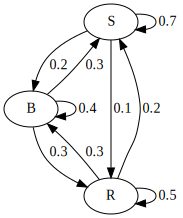

In [2]:
from graphviz import Digraph

dot = Digraph()

# Nodes
dot.node('S', 'S')
dot.node('B', 'B')
dot.node('R', 'R')

# Edges from S (row 1)
dot.edge('S', 'S', label='0.7')
dot.edge('S', 'B', label='0.2')
dot.edge('S', 'R', label='0.1')

# Edges from B (row 2)
dot.edge('B', 'S', label='0.3')
dot.edge('B', 'B', label='0.4')
dot.edge('B', 'R', label='0.3')

# Edges from R (row 3)
dot.edge('R', 'S', label='0.2')
dot.edge('R', 'B', label='0.3')
dot.edge('R', 'R', label='0.5')

dot

Eine Markov-Kette "erinnert" sich nur an den letzten Zustand. Soll bedeuten, die Wahl des nächsten Zustands hängt vom aktuellen Zustand ab. Bezogen auf natürliche Sprache bedeutet dies, das nächste Wort wird abhängig vom aktuellem gewählt, ergo ohne breiteren Kontext des Satzes. Zusätzlich muss alles was in einem Computer vorgeht durch Nummern repräsentiert werden. **Ein Computer kennt die Semantik eines Wortes nicht.**

---

# Word Embedding

Worteinbettungen sind eine Möglichkeit, Wörter als Vektoren in einem mehrdimensionalen Raum darzustellen, wobei der Abstand und die Richtung zwischen den Vektoren die Ähnlichkeit und Beziehungen zwischen den entsprechenden Wörtern widerspiegeln.

## Vektoren

Das Hauptziel von Worteinbettungen ist es, Wörter so darzustellen, dass ihre semantischen Beziehungen und Kontextinformationen erfasst werden. Diese Vektoren sind numerische Darstellungen in einem kontinuierlichen Vektorraum, wobei die relativen Positionen der Vektoren die semantischen Ähnlichkeiten und Beziehungen zwischen den Wörtern widerspiegeln.

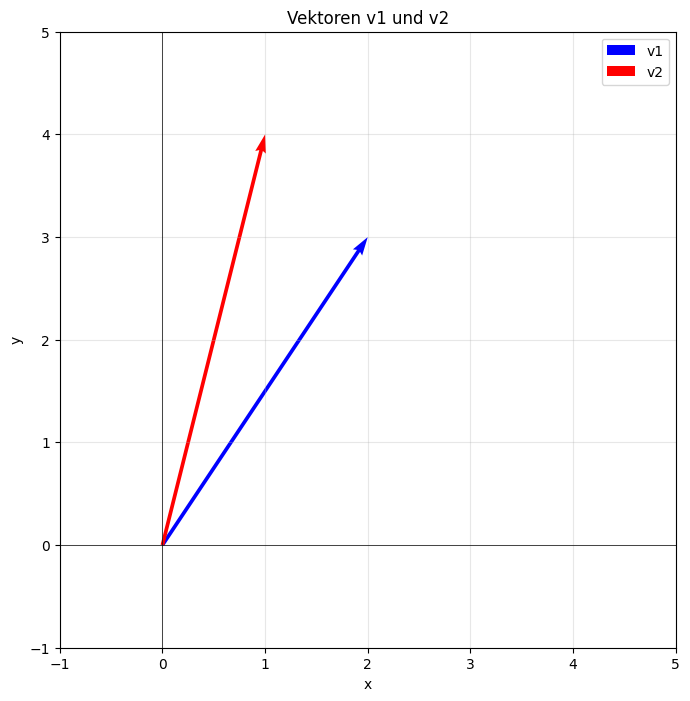

In [3]:
# Visualisierung der Vektoren
fig, ax = plt.subplots(figsize=(8, 8))

v1 = np.array([2, 3])
v2 = np.array([1, 4])

# Vektoren zeichnen
ax.quiver(
    0,
    0,
    v1[0],
    v1[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="blue",
    width=0.006,
    label="v1",
)
ax.quiver(
    0,
    0,
    v2[0],
    v2[1],
    angles="xy",
    scale_units="xy",
    scale=1,
    color="red",
    width=0.006,
    label="v2",
)


# Achsen einstellen
ax.set_xlim(-1, 5)
ax.set_ylim(-1, 5)
ax.set_aspect("equal")
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color="k", linewidth=0.5)
ax.axvline(x=0, color="k", linewidth=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Vektoren v1 und v2")
ax.legend()

plt.show()

Der Betrag des Abstandes zweier Endpunkte von Vektoren kann als semantische (Dis-)similarität gefasst werden. Liegen zwei Endpunkte näher bei einnander, dann sind die Begriffe sich Ähnlich, liegen sie weiter auseinnander, dann unterscheiden sie sich stärker.

In [4]:
# # Visualisierung der Vektoren
# fig, ax = plt.subplots(figsize=(8, 8))

# v1 = np.array([2, 3])
# v2 = np.array([1, 4])

# # v1
# ax.quiver(
#     0,
#     0,
#     v1[0],
#     v1[1],
#     angles="xy",
#     scale_units="xy",
#     scale=1,
#     color="blue",
#     width=0.006,
#     label="v1",
# )

# # v2
# ax.quiver(
#     0,
#     0,
#     v2[0],
#     v2[1],
#     angles="xy",
#     scale_units="xy",
#     scale=1,
#     color="red",
#     width=0.006,
#     label="v2",
# )

# # Verbindungsvektor von v1 nach v2
# v3 = v2 - v1
# ax.quiver(
#     v1[0],
#     v1[1],
#     v3[0],
#     v3[1],
#     angles="xy",
#     scale_units="xy",
#     scale=1,
#     color="green",
#     width=0.006,
#     label="v3",
# )


# # Achsen einstellen
# ax.set_xlim(-1, 5)
# ax.set_ylim(-1, 5)
# ax.set_aspect("equal")
# ax.grid(True, alpha=0.3)
# ax.axhline(y=0, color="k", linewidth=0.5)
# ax.axvline(x=0, color="k", linewidth=0.5)

# ax.set_xlabel("x")
# ax.set_ylabel("y")
# ax.set_title("Vektoren v1, v2 und v3")
# ax.legend()

# plt.show()

## Worte zu Vektoren (Word encoding / Tokens)


### Term Frequncy | Inverse Document Frequency

- **TF** misst wie oft ein Wort in einem Dokument vorkommt.
$$
\mathrm{TF}(t,d)
=
\frac{\text{Anzahl der Vorkommen des Terms } t \text{ in } d}
{\text{Gesamtzahl der Terme (Wörter) in } d}
$$
Alternativ geschrieben als $\mathrm{TF}(t,d)=\frac{f(t,d)}{|d|}$

- **IDF** misst wie wichtig ein Wort in dem unterliegenden Korpus ist.
$$
\mathrm{IDF}(t, D)
=
\log\!\left(
\frac{\text{Anzahl aller Dokumente}}
{\text{Anzahl der Dokumente, die den Term } t \text{ enthalten}}
\right)
$$

Diese Methode liefert zwar eine Methode zur nummerischen Messung der "Wichtigkeit" eines Wortes in einem Text, jedoch erkennt die nicht die Semantik und kann den Kontext des Wortes nicht in den Satzeinordnen. Auch Stoppwörter (ist, wie, als, ein, etc.) müssen entfernt werden. Schlussendlich liefert die Methode auch keinen Vektor mit dem wir die Semantik eines Wortes einordnen können.

### Word2Vec

Das Grundprinzip: Die Nachbarschafts-Analyse

Word2Vec lernt Bedeutung durch den Kontext. Der Algorithmus scannt riesige Textmengen mit einem "Schiebefenster". In der Mitte dieses Fensters steht das Zielwort, drumherum stehen die Kontextwörter.

Dafür gibt es zwei komplementäre Ansätze:
A) CBOW (Continuous Bag of Words)

Stellen Sie sich CBOW wie einen Lückentext-Test vor.

- Der Input: Das Modell sieht die Umgebung (z. B. "Der ___ krönt den Nachfolger").
-  Die Aufgabe: Es muss vorhersagen, welches Wort in die Lücke gehört ("König").
-  Das Ziel: Das Modell lernt, die gemeinsamen Merkmale der Umgebung zu nutzen, um auf das zentrale Wort zu schließen. Das ist sehr schnell und effektiv für häufig vorkommende Wörter.


B) Skip-gram

Das ist das Gegenstück zum CBOW.
- Der Input: Das Modell bekommt nur das zentrale Wort (z. B. "König").
- Die Aufgabe: Es muss vorhersagen, welche Wörter wahrscheinlich in der Nähe stehen könnten ("Krone", "Thron", "Regent").
- Das Ziel: Skip-gram funktioniert besonders gut bei seltenen Wörtern, da es die Beziehungen vom Wort ausgehend zu seinem Kontext lernt.

---

- CBOW "Der ___ setzt sich die Krone auf und sitzt auf den Thron".
- Skip-Gran von "König" umliegende Wörter zu erratten.

CBOW und das Skip-gran sind als inverses zu betrachten. CBOW = das Wort an seinem Nachbar erkennen, Skip-gran = die Nachbarn am Wort erkennen.

---

Das Geheimnis von Word2Vec ist, dass es ein einfaches neuronales Netz nutzt, um Gewichte zu lernen.

**Initialisierung**: Jedes Wort bekommt am Anfang eine völlig zufällige Liste von Zahlen (einen Vektor).

**Training**: Wenn das Modell bei CBOW "König" richtig errät, werden die Zahlenreihen von "König" und dem Kontext ("Krone") ein Stück ähnlicher gemacht.

**Korrektur**: Rät das Modell falsch (z. B. "Apfel"), werden die Zahlen von "Apfel" und "Krone" im mathematischen Raum voneinander weggeschoben.

Nach Milliarden solcher Vergleiche ordnen sich die Wörter wie von Geisterhand in einem hochdimensionalen Raum an.


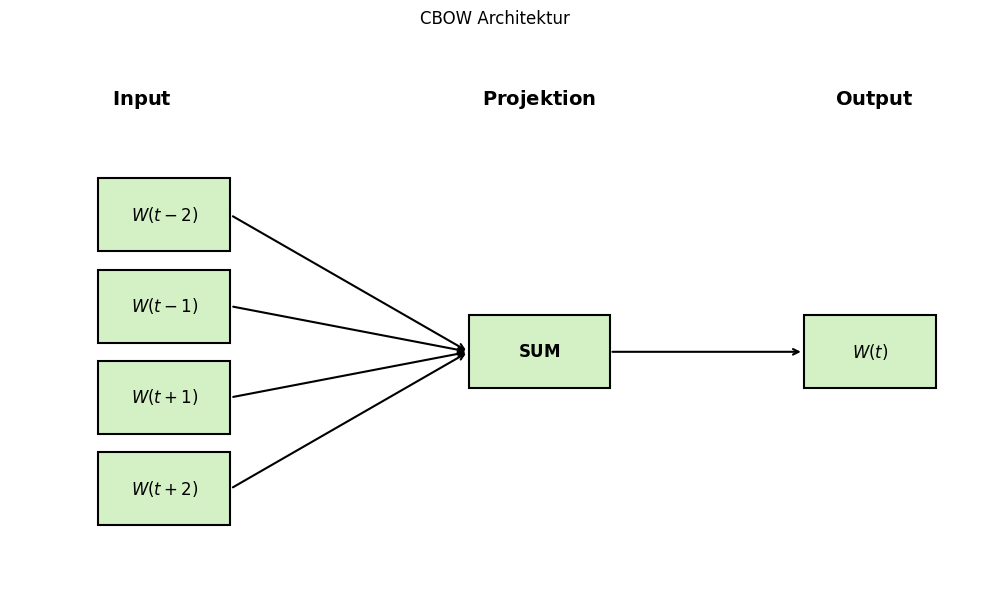

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


def draw_cbow_architecture():
    fig, ax = plt.subplots(figsize=(10, 6))

    # Styling-Konstanten (analog zu tikz styles)
    box_color = "#d4f1c5"  # Hellgrün (green!20)
    edge_color = "black"
    font_size = 12

    # Definition der Boxen: [x, y, label]
    inputs = [
        [0, 4, "$W(t-2)$"],
        [0, 3, "$W(t-1)$"],
        [0, 2, "$W(t+1)$"],
        [0, 1, "$W(t+2)$"],
    ]

    projection = [4.2, 2.5, r"$\mathbf{SUM}$"]
    output = [8, 2.5, "$W(t)$"]

    # Überschriften
    ax.text(0.5, 5.2, r"$\mathbf{Input}$", ha="center", fontsize=14)
    ax.text(5.0, 5.2, r"$\mathbf{Projektion}$", ha="center", fontsize=14)
    ax.text(8.8, 5.2, r"$\mathbf{Output}$", ha="center", fontsize=14)

    # Zeichne Input-Boxen und Pfeile zur SUM-Box
    for x, y, label in inputs:
        # Box zeichnen
        rect = patches.Rectangle(
            (x, y - 0.4),
            1.5,
            0.8,
            linewidth=1.5,
            edgecolor=edge_color,
            facecolor=box_color,
        )
        ax.add_patch(rect)
        ax.text(x + 0.75, y, label, ha="center", va="center", fontsize=font_size)

        # Pfeil zur Projection-Box (SUM)
        ax.annotate(
            "",
            xy=(4.2, 2.5),
            xytext=(1.5, y),
            arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
        )

    # Zeichne Projection-Box (SUM)
    rect_sum = patches.Rectangle(
        (4.2, 2.1), 1.6, 0.8, linewidth=1.5, edgecolor=edge_color, facecolor=box_color
    )
    ax.add_patch(rect_sum)
    ax.text(5.0, 2.5, projection[2], ha="center", va="center", fontsize=font_size)

    # Zeichne Output-Box
    rect_out = patches.Rectangle(
        (8, 2.1), 1.5, 0.8, linewidth=1.5, edgecolor=edge_color, facecolor=box_color
    )
    ax.add_patch(rect_out)
    ax.text(8.75, 2.5, output[2], ha="center", va="center", fontsize=font_size)

    # Pfeil von SUM zu Output
    ax.annotate(
        "",
        xy=(8, 2.5),
        xytext=(5.8, 2.5),
        arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
    )

    # Plot-Einstellungen
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 6)
    ax.axis("off")
    ax.set_title("CBOW Architektur")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    draw_cbow_architecture()

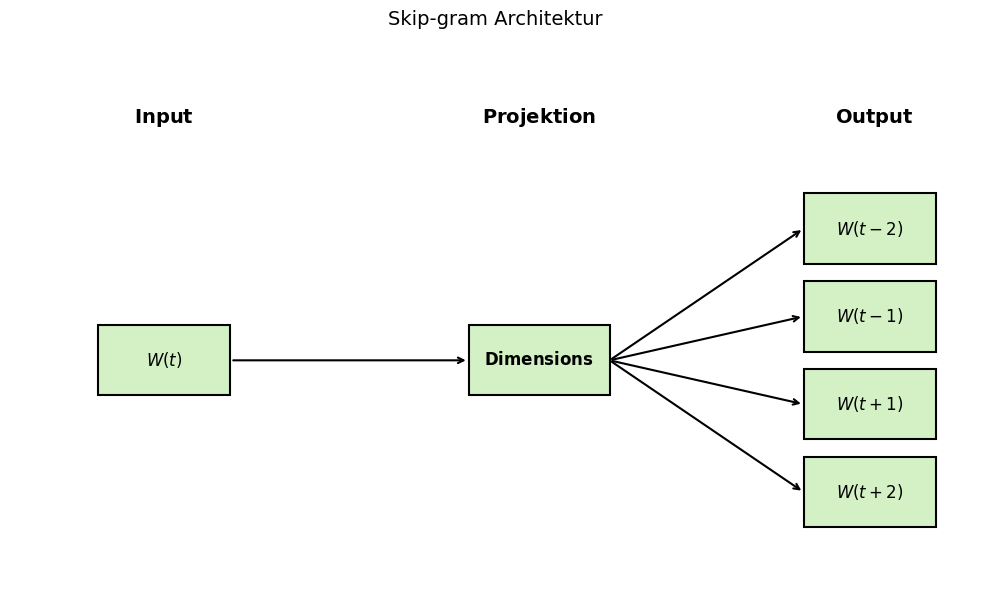

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_skipgram_architecture():
    fig, ax = plt.subplots(figsize=(10, 6))

    # Styling-Konstanten (analog zu deiner Vorlage)
    box_color = "#d4f1c5"  # Hellgrün
    edge_color = "black"
    font_size = 12

    # 1. INPUT (Ein einzelnes Wort in der Mitte)
    input_box = [0, 2.5, "$W(t)$"]
    
    # 2. PROJEKTION (Die Dimensionen/Vektor-Repräsentation)
    projection = [4.2, 2.5, r"$\mathbf{Dimensions}$"]
    
    # 3. OUTPUT (Mehrere Kontext-Wörter)
    outputs = [
        [8, 4, "$W(t-2)$"],
        [8, 3, "$W(t-1)$"],
        [8, 2, "$W(t+1)$"],
        [8, 1, "$W(t+2)$"],
    ]

    # Überschriften
    ax.text(0.75, 5.2, r"$\mathbf{Input}$", ha="center", fontsize=14)
    ax.text(5.0, 5.2, r"$\mathbf{Projektion}$", ha="center", fontsize=14)
    ax.text(8.8, 5.2, r"$\mathbf{Output}$", ha="center", fontsize=14)

    # Zeichne Input-Box
    rect_in = patches.Rectangle(
        (input_box[0], input_box[1] - 0.4), 1.5, 0.8, 
        linewidth=1.5, edgecolor=edge_color, facecolor=box_color
    )
    ax.add_patch(rect_in)
    ax.text(input_box[0] + 0.75, input_box[1], input_box[2], ha="center", va="center", fontsize=font_size)

    # Pfeil von Input zur Projektion
    ax.annotate(
        "",
        xy=(4.2, 2.5),
        xytext=(1.5, 2.5),
        arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
    )

    # Zeichne Projektions-Box
    rect_proj = patches.Rectangle(
        (projection[0], projection[1] - 0.4), 1.6, 0.8, 
        linewidth=1.5, edgecolor=edge_color, facecolor=box_color
    )
    ax.add_patch(rect_proj)
    ax.text(5.0, 2.5, projection[2], ha="center", va="center", fontsize=font_size)

    # Zeichne Output-Boxen und Pfeile von der Projektion
    for x, y, label in outputs:
        # Box zeichnen
        rect = patches.Rectangle(
            (x, y - 0.4), 1.5, 0.8,
            linewidth=1.5, edgecolor=edge_color, facecolor=box_color,
        )
        ax.add_patch(rect)
        ax.text(x + 0.75, y, label, ha="center", va="center", fontsize=font_size)

        # Pfeil von der Projektions-Box zum Output
        ax.annotate(
            "",
            xy=(x, y),
            xytext=(5.8, 2.5),
            arrowprops=dict(arrowstyle="->", lw=1.5, color="black"),
        )

    # Plot-Einstellungen
    ax.set_xlim(-1, 10)
    ax.set_ylim(0, 6)
    ax.axis("off")
    ax.set_title("Skip-gram Architektur", fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    draw_skipgram_architecture()

### Cosine Simmilarity

M
